In [2]:

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

Number of classes in dataset: 10
Number of images in dataset: 60000
Unique labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
4


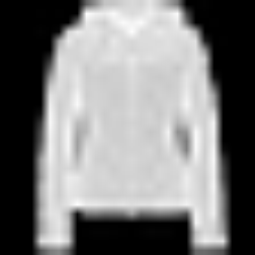

In [7]:

train_data = FashionMNIST(root='fashion-mnist', download=True)
print('Number of classes in dataset:', len(train_data.classes))
print('Number of images in dataset:', len(train_data))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[139]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

In [20]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the datasets
train_data = FashionMNIST(root='fashion-mnist/', train=True,
 download=True, transform=transform)
test_data = FashionMNIST(root='fashion-mnist/', train=False,
 download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.2 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

Training subset size: 12000
Test subset size: 2000


In [23]:
num_epochs = 10
lr = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
train_losses = []
val_losses = []

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, stride=1, padding=0),
    nn.Tanh(),
    # output size = (in - kernal_size + 2*padding) / stride + 1
    #output size = 28-5+1 = 24
    nn.MaxPool2d(kernel_size=2, stride=2),
    #output size = 24/2 = 12
    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0),
    nn.Tanh(),
    #output size = 12-5+1 = 8

    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
    nn.Flatten(), 
    nn.Linear(64*3*3, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 10),  
    nn.LogSoftmax(dim=1) 
)

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')


optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class


Using device cuda


In [25]:
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)  # convert to [N, 28*28] shape where N is batch_size
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)    # add loss for tracking. we'll visualize the loss trajectory later


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss:.3f}, val_loss={val_epoch_loss:.3f}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100:.3f}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

Epoch: 0, train_loss=0.256, val_loss=0.341. labelled 1763/2000 correctly (88.150% accuracy)
Epoch: 1, train_loss=0.237, val_loss=0.348. labelled 1753/2000 correctly (87.650% accuracy)
Epoch: 2, train_loss=0.227, val_loss=0.325. labelled 1781/2000 correctly (89.050% accuracy)
Epoch: 3, train_loss=0.212, val_loss=0.351. labelled 1758/2000 correctly (87.900% accuracy)
Epoch: 4, train_loss=0.198, val_loss=0.317. labelled 1781/2000 correctly (89.050% accuracy)
Epoch: 5, train_loss=0.186, val_loss=0.357. labelled 1755/2000 correctly (87.750% accuracy)
Epoch: 6, train_loss=0.177, val_loss=0.349. labelled 1762/2000 correctly (88.100% accuracy)
Epoch: 7, train_loss=0.163, val_loss=0.359. labelled 1762/2000 correctly (88.100% accuracy)
Epoch: 8, train_loss=0.153, val_loss=0.325. labelled 1797/2000 correctly (89.850% accuracy)
Epoch: 9, train_loss=0.138, val_loss=0.327. labelled 1770/2000 correctly (88.500% accuracy)
Training complete on device cuda. Change device variable and run again to see th